In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)

## Funciones

In [2]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

def simulate_price(mu: int | float, sigma: int | float, last_price: int | float, n_sims: int, n_days: int) -> np.ndarray:
    """
    mu y sigma diarios
    """
    Z = np.random.normal(size=(n_sims, n_days))
    returns = mu + sigma * Z
    cumulative_returns = (returns + 1).cumprod(axis=1)
    return last_price * cumulative_returns

def black_scholes_price(S: float, K: int | float, T: int | float, r: float, sigma: float, option_type: str = 'call') -> float:

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
    return price

def american_option_price(So: float, K: int | float , T: int | float, rf: float, sigma: float, n: int, option_type: str = 'call'):

    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    disc = np.exp(-rf * dt)
    p = (np.exp(rf * dt) - d) / (u - d)

    # Generar todos los precios posibles del subyacente en el último paso
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Valor terminal de la opción
    if option_type == 'put':
        option_values = np.maximum(K - ST, 0.0)
    else:
        option_values = np.maximum(ST - K, 0.0)

    # Backward induction
    for i in range(n - 1, -1, -1):
        ST = ST[:-1] / u  # precios del subyacente en el paso anterior
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

        # Valor por ejercicio anticipado
        if option_type == 'put':
            exercise = np.maximum(K - ST, 0.0)
        else:
            exercise = np.maximum(ST - K, 0.0)

        option_values = np.maximum(option_values, exercise)

    return option_values[0]

def plot_simulations(sim_prices):
    plt.figure(figsize=(10, 6))
    plt.plot(sim_prices.T)
    plt.title('Simulated Price Paths')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()

In [3]:
option = OptionPayoff()

## Precios

In [4]:
tickers = ['AAPL']
start_date = '2020-01-01'
end_date = '2025-04-14'

data = yf.download(tickers, start_date, end_date, progress=False)['Close']

rt = data.pct_change().dropna()

mu = rt.mean().values
sigma = rt.std().values
last_price = data.iloc[-1].values

YF.download() has changed argument auto_adjust default to True


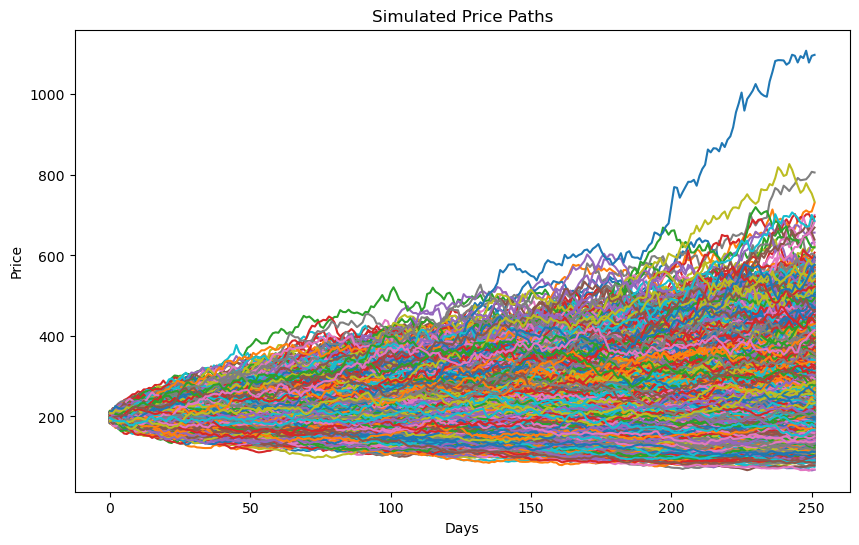

In [5]:
prices = simulate_price(mu, sigma, last_price, 10_000, 252)
plot_simulations(prices)

## Straddle

In [6]:
rows = 1000
columns_long_calls = 1
columns_long_puts = 1

long_calls = np.zeros((rows, columns_long_calls))
long_puts = np.zeros((rows, columns_long_puts))

st = np.linspace(140,230, rows)

In [7]:
strikes_long_calls = np.array([190])
premiums_long_calls = np.array([10])

strikes_long_puts = np.array([190])
premiums_long_puts = np.array([12])

long_calls[:, 0:] = option.long_call_payoff(st[:, None], strikes_long_calls, premiums_long_calls)
long_puts[:, 0:] = option.long_put_payoff(st[:, None], strikes_long_puts, premiums_long_puts)

strat_payoff = long_calls[:, 0:] + long_puts[:, 0:]

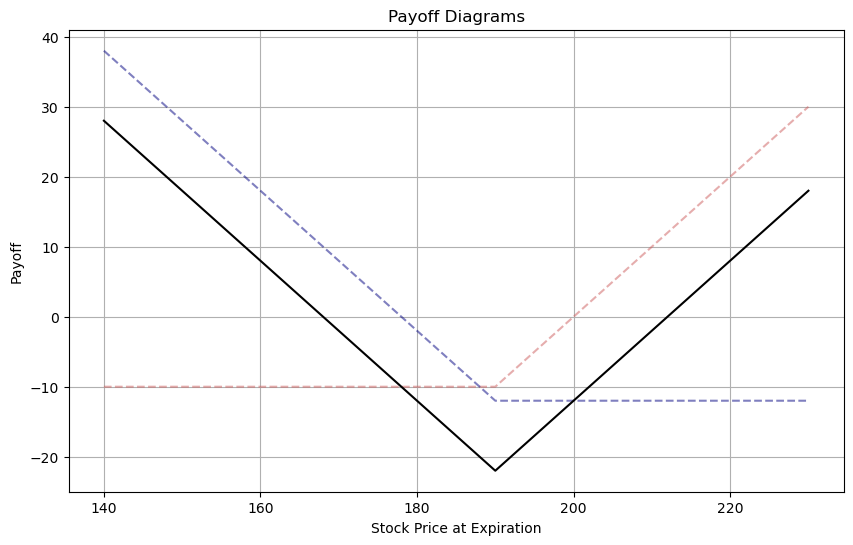

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(st, long_calls[:, 0], label='Long Call Payoff', linestyle='--', color='indianred', alpha = 0.5)
plt.plot(st, long_puts[:, 0], label='Long Put Payoff', linestyle='--', color='navy', alpha = 0.5)
plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')

plt.title('Payoff Diagrams')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Payoff')
plt.grid()
plt.show()

## Probability of Winning

In [9]:
last_prices_sim = prices[:, -1]
np.mean(last_prices_sim > 210), np.mean(last_prices_sim < 170)

(0.6637, 0.1484)

In [10]:
union = pd.DataFrame({
    'st': st,
    'strat_payoff': strat_payoff[:, 0],
})

new = union[union['strat_payoff'] <= 0]

new.head(1).index.values
new.tail(1).index.values

array([799])